# 🎬 Movie Rating Prediction with IMDb Dataset
This notebook walks through **step-by-step** how to build a machine learning model to predict IMDb movie ratings using Python.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

## 2. Load Dataset

In [2]:
file_path = "C:\\sahil\\project_folder\\codsoft task 2\\IMDb Movies India.csv"  # Change if needed
df = pd.read_csv(file_path, encoding='cp1252')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


## 3. Data Overview

In [3]:
df.info()

df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,15509,13838,Anjaam,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,14981,102,(2019),410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,7240,182,120 min,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,13632,485,Drama,2780,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,7919.0,NaN,NaN,NaN,5.841621,1.381777,1.1,4.9,6.0,6.8,10.0
Votes,7920,2034,8,227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Director,14984,5938,Jayant Desai,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1,13892,4718,Ashok Kumar,158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 2,13125,4891,Rekha,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 3,12365,4820,Pran,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Missing Values & Rating Distribution

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


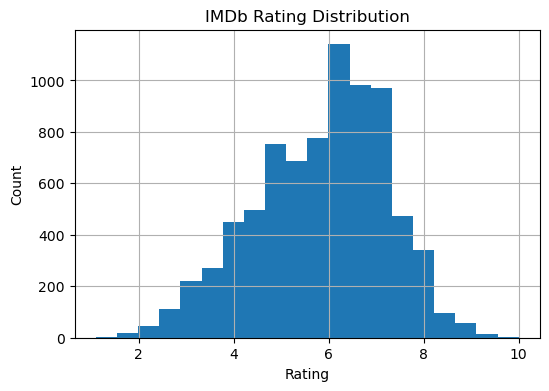

In [4]:
print(df.isnull().sum())

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
plt.figure(figsize=(6,4))
df['Rating'].dropna().hist(bins=20)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('IMDb Rating Distribution')
plt.show()

## 5. Feature Engineering

In [5]:
def build_features(df, top_directors=None, top_actors=None, all_genres=None):
    out = pd.DataFrame(index=df.index)
    # Numeric features
    out['Year_num'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0)
    out['Duration_num'] = pd.to_numeric(df['Duration'], errors='coerce').fillna(0)
    votes = pd.to_numeric(df['Votes'].astype(str).str.replace(',',''), errors='coerce').fillna(0)
    out['log_votes'] = np.log1p(votes)
    # Fill empty strings for categorical handling
    df = df.fillna('')
    # Genres
    if all_genres is None:
        genre_counts = df['Genre'].str.split(',').explode().str.strip().value_counts()
        all_genres = genre_counts[genre_counts>100].index.tolist()
    for g in all_genres:
        out[f'genre_{g}'] = df['Genre'].apply(lambda v: int(g in str(v)))
    # Directors
    if top_directors is None:
        top_directors = df['Director'].value_counts().head(30).index.tolist()
    for d in top_directors:
        out[f'dir_{d}'] = (df['Director']==d).astype(int)
    # Actors
    if top_actors is None:
        actors = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']])
        top_actors = actors.value_counts().head(50).index.tolist()
    for a in top_actors:
        out[f'actor_{a}'] = ((df['Actor 1']==a)|(df['Actor 2']==a)|(df['Actor 3']==a)).astype(int)
    return out, top_directors, top_actors, all_genres

# Prepare data
df_model = df.dropna(subset=['Rating']).copy()
X, top_directors, top_actors, all_genres = build_features(df_model)
y = df_model['Rating']
X.shape, y.shape

((7919, 99), (7919,))

## 6. Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((6335, 99), (1584, 99))

## 7. Train Multiple Models

In [14]:
# Step 4: Model Training and Evaluation
# Train the model using the training data.
print("\nTraining the Random Forest Regressor...")
model.fit(X_train, y_train)

# Make predictions on the test data.
y_pred = model.predict(X_test)

# Evaluate the model's performance using common regression metrics.
# MAE: Mean Absolute Error - The average absolute difference between predicted and actual values. Lower is better.
mae = mean_absolute_error(y_test, y_pred)
# MSE: Mean Squared Error - The average of the squared differences. Penalizes larger errors more. Lower is better.
mse = mean_squared_error(y_test, y_pred)
# RMSE: Root Mean Squared Error - The square root of the MSE. It's in the same unit as the target variable (Rating).
rmse = np.sqrt(mse)
# R-squared: R² score - The proportion of variance explained by the model. Closer to 1 is better.
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Training the Random Forest Regressor...

Model Evaluation Results:
Mean Absolute Error (MAE): 0.9475
Mean Squared Error (MSE): 1.4363
Root Mean Squared Error (RMSE): 1.1985
R-squared (R²): 0.2274


## 8. Feature Importances (Tree-based Models)

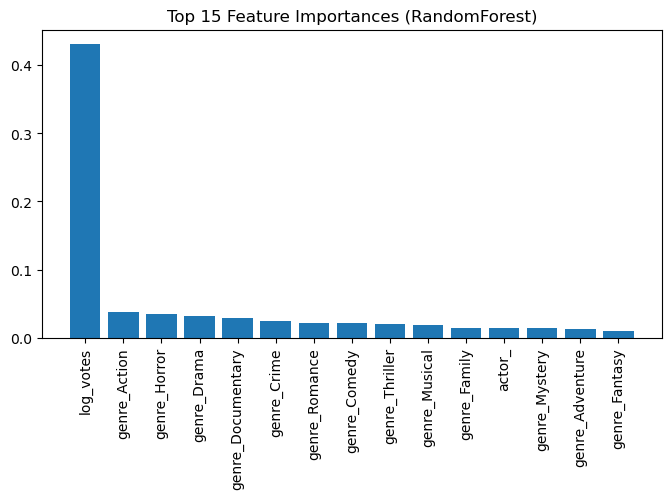

In [9]:
best_model = models['RandomForest']
importances = best_model.feature_importances_
idx = np.argsort(importances)[-15:][::-1]
plt.figure(figsize=(8,4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [X.columns[i] for i in idx], rotation=90)
plt.title('Top 15 Feature Importances (RandomForest)')
plt.show()

## 9. Save Model

In [10]:
bundle = {
    'model': best_model,
    'features': X.columns.tolist(),
    'top_directors': top_directors,
    'top_actors': top_actors,
    'all_genres': all_genres
}
joblib.dump(bundle, 'imdb_rating_model.pkl')
print('Model saved as imdb_rating_model.pkl')

Model saved as imdb_rating_model.pkl


## 10. Predict on New Movies

In [11]:
# Example: use same df for demonstration
X_new, _, _, _ = build_features(df, top_directors, top_actors, all_genres)
model = joblib.load('imdb_rating_model.pkl')['model']
preds = model.predict(X_new)
df['Predicted_Rating'] = preds
df[['Name', 'Year', 'Rating', 'Predicted_Rating']].head()

,Name,Year,Rating,Predicted_Rating
0,,NaN,NaN,6.206301
1,#Gadhvi (He thought he was Gandhi),(2019),7.0,6.654230
2,#Homecoming,(2021),NaN,5.758730
3,#Yaaram,(2019),4.4,4.756367
4,...And Once Again,(2010),NaN,6.206301


In [18]:
import pandas as pd
import joblib
import numpy as np

# Load the model bundle
bundle = joblib.load("imdb_rating_model.pkl")
model = bundle['model']
top_directors = bundle['top_directors']
top_actors = bundle['top_actors']
all_genres = bundle['all_genres']

# Reuse the feature engineering function
def build_features(df, top_directors, top_actors, all_genres):
    out = pd.DataFrame(index=df.index)

    # Numeric features
    out['Year_num'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0)
    out['Duration_num'] = pd.to_numeric(df['Duration'], errors='coerce').fillna(0)
    votes = pd.to_numeric(df['Votes'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
    out['log_votes'] = np.log1p(votes)

    # Fill empty strings for categorical handling
    df = df.fillna('')

    # Genres
    for g in all_genres:
        out[f'genre_{g}'] = df['Genre'].apply(lambda v: int(g in str(v)))

    # Directors
    for d in top_directors:
        out[f'dir_{d}'] = (df['Director'] == d).astype(int)

    # Actors
    for a in top_actors:
        out[f'actor_{a}'] = (
            (df['Actor 1'] == a) |
            (df['Actor 2'] == a) |
            (df['Actor 3'] == a)
        ).astype(int)

    return out

# Example: predict rating for a new movie
new_movie = pd.DataFrame([{
    "Name": "Test Movie",
    "Year": 2025,
    "Duration": 140,
    "Genre": "Drama, Action",
    "Director": "Rajkumar Hirani",
    "Actor 1": "Aamir Khan",
    "Actor 2": "Kareena Kapoor",
    "Actor 3": "Sharman Joshi",
    "Votes": "50000"
}])

# Build features and predict
X_new = build_features(new_movie, top_directors, top_actors, all_genres)
predicted_rating = model.predict(X_new)[0]

print(f"🎬 Predicted IMDb Rating for '{new_movie['Name'][0]}': {predicted_rating:.2f}")


🎬 Predicted IMDb Rating for 'Test Movie': 7.74
